#**Transpose Attack : Stealing Dataset with bidirectional training**
This notebook:
- trains a classifier (primary task) on MNIST
- trains a transposed reconstruction model (secondary task) using shared weights
- demonstrates memorization (reconstruction) using Gray-code spatial indices
- provides evaluation (accuracy, MSE, SSIM, feature-accuracy)
- includes a detection routine and a simple noise mitigation test

# **Setup & Installs**

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q scikit-image tqdm
import torch, torchvision
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())

Torch: 2.8.0+cu126 CUDA available: False


# **Imports and utilities**

In [ ]:
import os
import math
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from skimage.metrics import structural_similarity as ssim
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# **Gray-code indexer + class embedding (spatial indexer)**

In [ ]:
def int_to_nary(x, base, length):
    """Convert integer x to base-n digits of fixed length (LSB last)."""
    digits = []
    for _ in range(length):
        digits.append(int(x % base))
        x //= base
    return list(reversed(digits))

def nary_gray(x, base, length):
    """
    Simple n-ary Gray mapping: convert to base-n then apply prefix-sum mod base.
    This keeps neighbors closer in L2 compared to naive base-n.
    """
    digits = int_to_nary(x, base, length)
    # apply cumulative sum modulo base -> Gray-like
    out = []
    acc = 0
    for d in digits:
        acc = (acc + d) % base
        out.append(acc)
    # normalize to [0,1]
    out = np.array(out, dtype=np.float32) / float(base-1)
    return out

class SpatialIndexer:
    def __init__(self, code_dim=16, base=3, n_classes=10, class_embed='onehot'):
        self.code_dim = code_dim
        self.base = base
        self.n_classes = n_classes
        self.class_embed = class_embed
        if class_embed == 'onehot':
            self.class_emb = np.zeros((n_classes, code_dim), dtype=np.float32)
            block = code_dim // n_classes if n_classes <= code_dim else 1
            for c in range(n_classes):
                idx = c % code_dim
                self.class_emb[c, idx] = 1.0
        elif class_embed == 'random':
            self.class_emb = np.random.RandomState(1234).randn(n_classes, code_dim).astype(np.float32)
        else:
            raise ValueError("unknown class_embed")
    def index(self, i, c):
        g = nary_gray(i, self.base, self.code_dim)
        return g + self.class_emb[c]


# **MNIST memorization dataset using spatial indices**

In [ ]:
class MNIST_Mem_Dataset(Dataset):
    def __init__(self, percentage=0.1, code_dim=16, base=3, class_embed='onehot', root='./data'):
        mn = datasets.MNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
        self.n_total = len(mn)
        k = max(1, int(self.n_total * percentage))
        labels = np.array(mn.targets)
        per_class = max(1, k // 10)
        chosen_idx = []
        for cls in range(10):
            cls_idx = np.where(labels == cls)[0]
            np.random.shuffle(cls_idx)
            chosen_idx.extend(cls_idx[:per_class])
        if len(chosen_idx) < k:
            all_idx = np.arange(self.n_total)
            np.random.shuffle(all_idx)
            for idx in all_idx:
                if idx not in chosen_idx:
                    chosen_idx.append(int(idx))
                if len(chosen_idx) >= k:
                    break
        chosen_idx = chosen_idx[:k]
        self.samples = [ (mn.data[int(i)].unsqueeze(0).float()/255.0, int(mn.targets[int(i)])) for i in chosen_idx ]
        self.indexer = SpatialIndexer(code_dim=code_dim, base=base, n_classes=10, class_embed=class_embed)
        self.class_lists = {c:[] for c in range(10)}
        for idx, (_, lbl) in enumerate(self.samples):
            self.class_lists[lbl].append(idx)
        self.idx_to_pos = {}
        for c in range(10):
            for pos, sample_idx in enumerate(self.class_lists[c]):
                self.idx_to_pos[sample_idx] = pos
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img, lbl = self.samples[idx]
        pos = self.idx_to_pos[idx]
        code = self.indexer.index(pos, lbl)
        return torch.tensor(code, dtype=torch.float32), torch.tensor(lbl, dtype=torch.long), img.view(-1)


# **Simple MNIST flattening transform**

In [ ]:
class FlattenTransform:
    def __call__(self, x):
        return x.view(-1)

# **Model: MemNetFC (shared weights + strict transpose)**

In [ ]:
class MemNetFC(nn.Module):
    def __init__(self, input_size=784, output_size=10, hidden_layers=[1024,1024,1024], act=F.relu):
        super().__init__()
        sizes = [input_size] + hidden_layers + [output_size]
        self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1], bias=True) for i in range(len(sizes)-1)])
        self.act = act
        self.input_size = input_size
        self.output_size = output_size
    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        out = self.layers[-1](out)
        return out
    def forward_transposed(self, code):
        out = code
        for layer in reversed(self.layers):
            W = layer.weight
            out = F.linear(out, W.t())
            out = self.act(out)
        return torch.sigmoid(out)


# **Model: MemNetCNN (conv + pooling forward, conv-transpose + upsample backward)**

In [ ]:
class MemNetCNN(nn.Module):
    def __init__(self, img_size=28, n_classes=10, base_channels=32, code_dim=16):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc_in = (base_channels*2)*(img_size//2)*(img_size//2)
        self.fc1 = nn.Linear(self.fc_in, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.act = F.relu
        self.code_dim = code_dim
        self.code_to_fc = nn.Linear(code_dim, self.fc_in)
    def forward(self, x):
        out = self.act(self.conv1(x))
        out = self.pool(self.act(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        return out
    def forward_transposed(self, code):
        b = code.shape[0]
        fc_feat = self.code_to_fc(code)
        feat = self.act(fc_feat).view(b, (self.fc_in)//((28//2)*(28//2)), 28//2, 28//2)
        feat = F.conv_transpose2d(feat, self.conv2.weight, stride=1, padding=1)
        feat = self.act(feat)
        feat = F.interpolate(feat, scale_factor=2, mode='nearest')
        rec = F.conv_transpose2d(feat, self.conv1.weight, stride=1, padding=1)
        rec = torch.sigmoid(rec)
        return rec.view(b, -1)


# **Auxiliary classifier for "feature-accuracy" evaluation**

In [ ]:
class SmallClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*14*14, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(F.relu(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# **Data loaders: classification (train/test) and memorization dataset**

In [ ]:
batch_size = 128
code_dim = 10
percentage_to_memorize = 0.1

transform_flat = transforms.Compose([transforms.ToTensor(), FlattenTransform()])
transform_img = transforms.Compose([transforms.ToTensor()])

train_cls = datasets.MNIST('./data', train=True, download=True, transform=transform_flat)
test_cls  = datasets.MNIST('./data', train=False, download=True, transform=transform_flat)
train_loader_cls = DataLoader(train_cls, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_cls  = DataLoader(test_cls, batch_size=batch_size, shuffle=False, pin_memory=True)

train_cls_img = datasets.MNIST('./data', train=True, download=True, transform=transform_img)
test_cls_img  = datasets.MNIST('./data', train=False, download=True, transform=transform_img)
train_loader_cls_img = DataLoader(train_cls_img, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader_cls_img  = DataLoader(test_cls_img, batch_size=batch_size, shuffle=False, pin_memory=True)

mem_dataset = MNIST_Mem_Dataset(percentage=percentage_to_memorize, code_dim=code_dim, base=3, class_embed='onehot')

mem_loader = DataLoader(mem_dataset, batch_size=batch_size, shuffle=True)
print("Memorize dataset size:", len(mem_dataset))

Memorize dataset size: 6000


# **Training loop (alternating classification + memorization)**

In [ ]:
def train_transpose_fc(model, train_loader_cls, mem_loader, epochs=40, lr_cls=1e-4, lr_mem=1e-3, save_path='./mnist_fc_transpose.pth'):
    model.to(device)
    opt_cls = optim.Adam(model.parameters(), lr=lr_cls)
    opt_mem = optim.Adam(model.parameters(), lr=lr_mem)
    loss_cls = nn.CrossEntropyLoss()
    loss_mem = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        mem_iter = iter(mem_loader)
        pbar = tqdm(train_loader_cls, desc=f"Epoch {epoch+1}/{epochs}")
        total_cls_loss = 0.0
        total_mem_loss = 0.0
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt_cls.zero_grad()
            logits = model(x)
            l1 = loss_cls(logits, y)
            l1.backward()
            opt_cls.step()
            total_cls_loss += l1.item()
            try:
                code, lbl, img_flat = next(mem_iter)
            except StopIteration:
                mem_iter = iter(mem_loader)
                code, lbl, img_flat = next(mem_iter)
            code = code.to(device)
            img_flat = img_flat.to(device)
            opt_mem.zero_grad()
            rec = model.forward_transposed(code)
            l2 = loss_mem(rec, img_flat)
            l2.backward()
            opt_mem.step()
            total_mem_loss += l2.item()
            pbar.set_postfix({'cls_loss': f"{total_cls_loss:.4f}", 'mem_loss': f"{total_mem_loss:.6f}"})
        torch.save({'net': model.state_dict()}, save_path)
    return model

def train_transpose_cnn(model, train_loader_cls_img, mem_loader, epochs=30, lr_cls=1e-4, lr_mem=1e-3, save_path='./mnist_cnn_transpose.pth'):
    model.to(device)
    opt_cls = optim.Adam(model.parameters(), lr=lr_cls)
    opt_mem = optim.Adam(model.parameters(), lr=lr_mem)
    loss_cls = nn.CrossEntropyLoss()
    loss_mem = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        mem_iter = iter(mem_loader)
        pbar = tqdm(train_loader_cls_img, desc=f"Epoch {epoch+1}/{epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt_cls.zero_grad()
            logits = model(x)
            l1 = loss_cls(logits, y)
            l1.backward()
            opt_cls.step()
            try:
                code, lbl, img_flat = next(mem_iter)
            except StopIteration:
                mem_iter = iter(mem_loader)
                code, lbl, img_flat = next(mem_iter)
            code = code.to(device)
            img_flat = img_flat.to(device)
            opt_mem.zero_grad()
            rec_flat = model.forward_transposed(code)
            l2 = loss_mem(rec_flat, img_flat)
            l2.backward()
            opt_mem.step()
            pbar.set_postfix({'cls_loss': f"{l1.item():.4f}", 'mem_loss': f"{l2.item():.6f}"})
        torch.save({'net': model.state_dict()}, save_path)
    return model


# **Run training (smaller epochs here for demo; increase as desired)**

In [ ]:
fc_model = MemNetFC(input_size=784, output_size=10,
                    hidden_layers=[1024,1024,1024])

fc_model = train_transpose_fc(fc_model, train_loader_cls, mem_loader, epochs=12, lr_cls=1e-4, lr_mem=1e-3, save_path='./mnist_fc_transpose.pth')

cnn_model = MemNetCNN(img_size=28, n_classes=10, base_channels=32, code_dim=code_dim)
cnn_model = train_transpose_cnn(cnn_model, train_loader_cls_img, mem_loader, epochs=10, lr_cls=1e-4, lr_mem=1e-3, save_path='./mnist_cnn_transpose.pth')


Epoch 10/10: 100%|██████████| 469/469 [03:53<00:00,  2.01it/s, cls_loss=0.0321, mem_loss=0.051729]


# **Evaluate classification accuracy (primary task)**

In [ ]:
def test_acc(model, test_loader, is_cnn=False):
    model.to(device)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            if is_cnn:
                logits = model(x)
            else:
                logits = model(x.view(x.size(0), -1))
            preds = logits.argmax(dim=1)
            total += y.size(0)
            correct += (preds == y).sum().item()
    return correct / total

acc_fc = test_acc(fc_model, test_loader_cls, is_cnn=False)
acc_cnn = test_acc(cnn_model, test_loader_cls_img, is_cnn=True)
print("FC primary accuracy (test):", acc_fc)
print("CNN primary accuracy (test):", acc_cnn)

FC primary accuracy (test): 0.9633
CNN primary accuracy (test): 0.9877


# **Visualize memorized reconstructions + compute MSE & SSIM**

FC reconstructions:


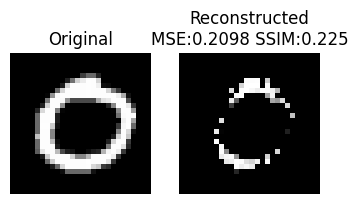

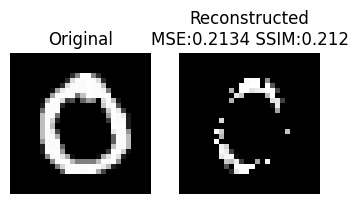

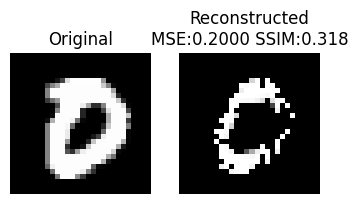

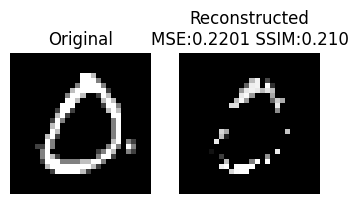

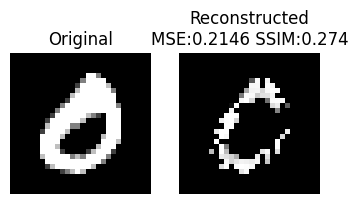

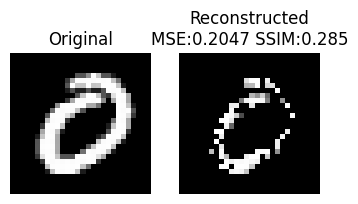

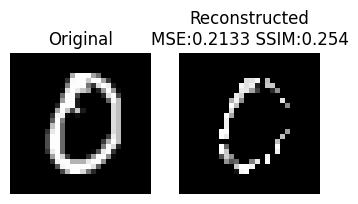

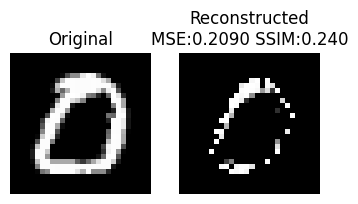

Mean MSE (FC): 0.21061149 Mean SSIM (FC): 0.2520478391954144
CNN reconstructions:


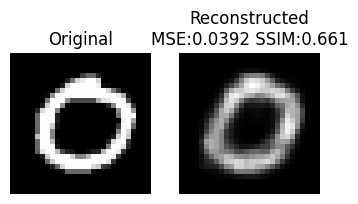

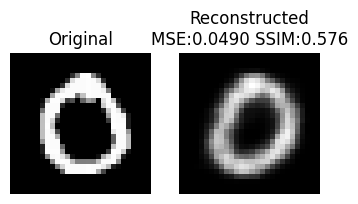

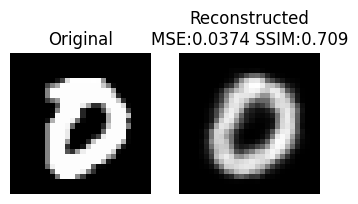

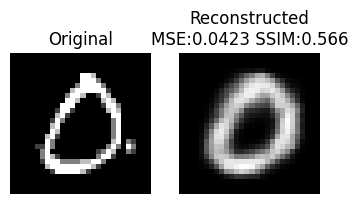

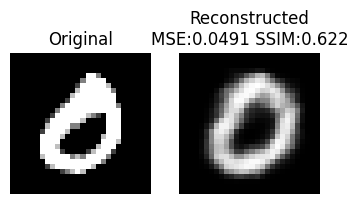

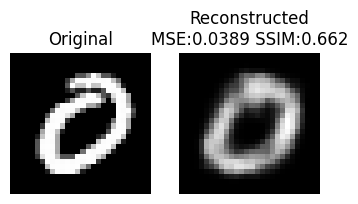

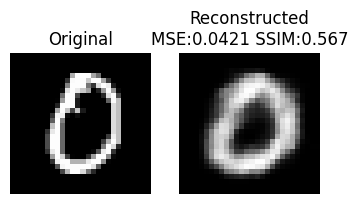

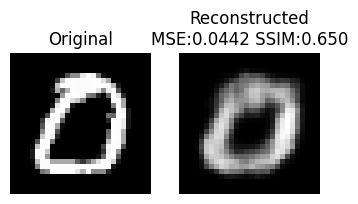

Mean MSE (CNN): 0.042768445 Mean SSIM (CNN): 0.6266384466213074


In [ ]:
def visualize_memorized(model, mem_dataset, max_plot=10, is_cnn=False):
    model.to(device)
    model.eval()
    mse_list = []
    ssim_list = []
    for idx in range(min(len(mem_dataset), max_plot)):
        code, lbl, img_flat = mem_dataset[idx]
        code_t = code.unsqueeze(0).to(device)
        with torch.no_grad():
            rec = model.forward_transposed(code_t)
        if is_cnn:
            rec_img = rec.view(28,28).cpu().numpy()
        else:
            rec_img = rec.view(-1, 28,28).squeeze(0).cpu().numpy()
        orig_img = img_flat.view(28,28).cpu().numpy()
        mse = ((orig_img - rec_img)**2).mean()
        try:
            s = ssim(orig_img, rec_img, data_range=1.0)
        except:
            s = 0.0
        mse_list.append(mse)
        ssim_list.append(s)
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1); plt.title("Original"); plt.imshow(orig_img, cmap='gray'); plt.axis('off')
        plt.subplot(1,2,2); plt.title(f"Reconstructed\nMSE:{mse:.4f} SSIM:{s:.3f}"); plt.imshow(rec_img, cmap='gray'); plt.axis('off')
        plt.show()
    return np.mean(mse_list), np.mean(ssim_list)

print("FC reconstructions:")
mse_fc, ssim_fc = visualize_memorized(fc_model, mem_dataset, max_plot=8, is_cnn=False)
print("Mean MSE (FC):", mse_fc, "Mean SSIM (FC):", ssim_fc)
print("CNN reconstructions:")
mse_cnn, ssim_cnn = visualize_memorized(cnn_model, mem_dataset, max_plot=8, is_cnn=True)
print("Mean MSE (CNN):", mse_cnn, "Mean SSIM (CNN):", ssim_cnn)


# **Feature-accuracy: train small classifier on reconstructions**

In [ ]:
def assemble_reconstructed_dataset(model, mem_dataset, is_cnn=False):
    X = []
    Y = []
    model.eval()
    with torch.no_grad():
        for i in range(len(mem_dataset)):
            code, lbl, img_flat = mem_dataset[i]
            rec = model.forward_transposed(code.unsqueeze(0).to(device))
            rec_img = rec.view(1, 1, 28, 28).cpu()
            X.append(rec_img.squeeze(0))
            Y.append(int(lbl.item()))
    X = torch.stack(X)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y

X_rec_fc, Y_rec_fc = assemble_reconstructed_dataset(fc_model, mem_dataset, is_cnn=False)
print("Reconstructed dataset size (FC):", X_rec_fc.shape)
clf = SmallClassifier().to(device)
opt = optim.Adam(clf.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(6):
    clf.train()
    perm = torch.randperm(X_rec_fc.size(0))
    losses = []
    for i in range(0, X_rec_fc.size(0), 64):
        idx = perm[i:i+64]
        xb = X_rec_fc[idx].to(device)
        yb = Y_rec_fc[idx].to(device)
        opt.zero_grad()
        logits = clf(xb)
        l = loss(logits, yb)
        l.backward()
        opt.step()
        losses.append(l.item())
    print("epoch", epoch, "loss", np.mean(losses))
def eval_clf_on_test(clf, test_loader):
    clf.eval()
    total = 0; correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = clf(x)
            preds = logits.argmax(dim=1)
            total += y.size(0); correct += (preds==y).sum().item()
    return correct/total

acc_retrained = eval_clf_on_test(clf, test_loader_cls_img)
print("Feature-accuracy: accuracy of classifier trained on reconstructions (tested on real MNIST test):", acc_retrained)


Reconstructed dataset size (FC): torch.Size([6000, 1, 28, 28])
epoch 0 loss 1.35731740137364
epoch 1 loss 0.5202950895466703
epoch 2 loss 0.4639117226321646
epoch 3 loss 0.43919775000912076
epoch 4 loss 0.4258258417248726
epoch 5 loss 0.4111428167274658
Feature-accuracy: accuracy of classifier trained on reconstructions (tested on real MNIST test): 0.6942


# **Detection routine (optimize code to reproduce dataset mean)**

Running detection probe on FC model (this may take a moment)...


/tmp/ipython-input-535906115.py:11: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([1, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(rec, dataset_mean.to(device))


Best MSE found: 0.16409023


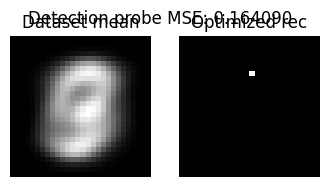

In [ ]:
def detection_probe(model, dataset_mean, code_dim=16, steps=300, lr=1e-2, restarts=5, is_cnn=False):
    best = 1e9
    best_img = None
    for r in range(restarts):
        e = torch.rand((1, code_dim), device=device, requires_grad=True)
        opt = optim.Adam([e], lr=lr)
        for i in range(steps):
            opt.zero_grad()
            rec = model.forward_transposed(e)
            loss = F.mse_loss(rec, dataset_mean.to(device))
            loss.backward()
            opt.step()
        with torch.no_grad():
            rec_final = model.forward_transposed(e).detach().cpu().numpy().reshape(28,28)
            lval = ((rec_final - dataset_mean.cpu().numpy().reshape(28,28))**2).mean()
            if lval < best:
                best = lval
                best_img = rec_final
    return best, best_img

mn_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mean_img = mn_train.data.float()/255.0
mean_img = mean_img.mean(dim=0).view(-1)
print("Running detection probe on FC model (this may take a moment)...")
best_mse, best_img = detection_probe(fc_model, mean_img, code_dim=code_dim, steps=300, lr=1e-2, restarts=3, is_cnn=False)
print("Best MSE found:", best_mse)
plt.figure(figsize=(4,2))
plt.subplot(1,2,1); plt.imshow(mean_img.view(28,28).numpy(), cmap='gray'); plt.title("Dataset mean"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(best_img, cmap='gray'); plt.title("Optimized rec"); plt.axis('off')
plt.suptitle(f"Detection probe MSE: {best_mse:.6f}")
plt.show()


# **Simple mitigation experiment: add gaussian noise to weights and test reconstructions**

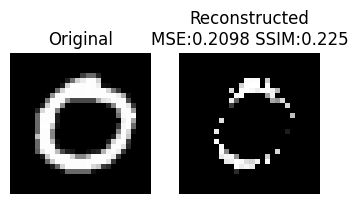

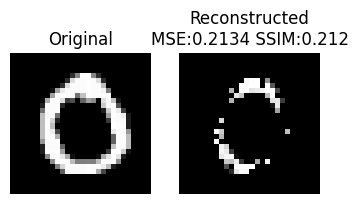

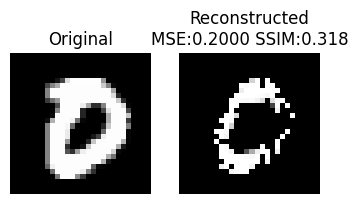

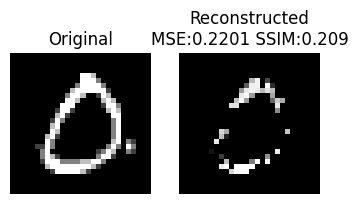

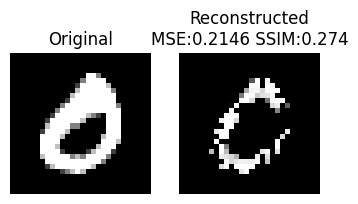

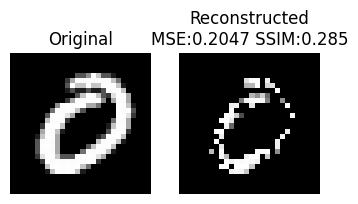

Noisy model MSE: 0.21043076 SSIM: 0.2536591552778807


In [ ]:
def add_noise_to_state(model, std):
    for p in model.parameters():
        p.data.add_(torch.randn_like(p)*std)

model_noisy = deepcopy(fc_model)
add_noise_to_state(model_noisy, std=5e-4)
mse_noisy, ssim_noisy = visualize_memorized(model_noisy, mem_dataset, max_plot=6, is_cnn=False)
print("Noisy model MSE:", mse_noisy, "SSIM:", ssim_noisy)
